# Figure 4: Model of the response dynamics under continuous treatment at 100 $\mu$M

In [4]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from lmfit import minimize, Parameters
from itertools import product
import multiprocess as mp

# Import my own libraries
sys.path.append('./utils/')
import myUtils as utils
from odeModels import MakeModelFromStr
from fittingUtils import residual, ComputeRSquared, PlotFit, PlotData, LoadFit, \
                            perform_bootstrap, compute_confidenceInterval_prediction, \
                            benchmark_prediction_accuracy, compute_confidenceInterval_parameters

# Format plot
sns.set(style="white",
        rc={'figure.figsize':(12,6), 'xtick.labelsize': 22, 'ytick.labelsize': 22})

In [11]:
# Data and solver configurations
cellLine = "OVCAR3"
runFitting = True
n_bootstraps = 25 # Number of bootstraps used in uncertainty estimation
ci_significanceLevel = 0.95 # Significance level for confidence and prediction intervals
solver_kws={'method':'DOP853', 'absErr':1.0e-8, 'relErr':1.0e-6, 'suppressOutputB':False}
optimiser_kws = {'method':'least_squares', 'xtol':1e-8, 'ftol':1e-8,
                 'nan_policy':'omit', 'verbose':2}

# Load growth model parameters
growthModel = "GeneralisedLogistic"
fitObj,_ = LoadFit(growthModel,fitDir=os.path.join("./fits/growthModel/%s"%cellLine,growthModel))
params = fitObj.params
params['r'].set(vary=False)
params['K'].set(vary=False)
params['v'].set(vary=False)
params['N0'].set(vary=False)

# Environment
nProcesses = 4 # Number of cores to use for bootstrapping
dataDir = "./data/"
modelDir = "./fits/"
cycleArrestModelPalette = {"TumourSize":sns.xkcd_rgb['ocean blue'],
                      "P":'g',
                      "A":'purple'}

In [6]:
# Load the treatment data for model development and testing
dataDf_all = pd.read_csv("./data/intermittentTreatmentDf_cleaned.csv", index_col=0)
dataDf_all = dataDf_all[(dataDf_all.DMax==100) & (dataDf_all.CellLine==cellLine)] # Only select 100uM experiment here. Will use 50uM when developing the dose-resoponse model

# For model development, use the data for CT treatment
trainingDataDf_all = dataDf_all[dataDf_all.Delay==100]
trainingDataDf_avg = trainingDataDf_all.groupby(by="Time").mean().reset_index()

# For model testing, use the data from the 7d-on experiment
testingDataDf_all = dataDf_all[dataDf_all.Delay==7]
testingDataDf_avg = testingDataDf_all.groupby(by="Time").mean().reset_index()

## b) Calibrate and test a model which assumes PARPi exposure induces cell cycle arrest at the next division (Single Step Model)

In [13]:
# Parameters
modelName = "CycleArrestModel_singleStep"
params.add('alpha', value=5e-1, min=0, max=1, vary=True)
params.add('beta', value=0.1, min=0, max=5e-1, vary=True)
params.add('d_A', value=5e-2, min=0, max=5e-1, vary=True)
params.add('P0', value=10, min=0, max=100., vary=False)
params.add('A0', value=0, vary=False)

currOutDir = os.path.join(modelDir, "treatmentModel", cellLine, modelName)
utils.mkdir(currOutDir);

### Carry out fitting

In [14]:
if runFitting:
    # Setup env
    tmpModel = MakeModelFromStr(modelName)
    currParams = Parameters()
    currParams.add_many(*[params[x] for x in tmpModel.paramDic.keys()])
    if currParams['P0'].vary==False: currParams['P0'].value = trainingDataDf_avg.Confluence.iloc[0]    

    # Fit
    fitObj = minimize(residual, currParams, args=(0, trainingDataDf_avg, tmpModel, "Confluence", solver_kws),**optimiser_kws)
    fitObj.fitId = 0
    fitObj.modelName = modelName
    fitObj.data = trainingDataDf_avg
    fitObj.rSq = ComputeRSquared(fitObj, trainingDataDf_avg)

    # Post-process
    pickle.dump(obj=fitObj, file=open(os.path.join(currOutDir,"fitObj_fit_%d.p"%(fitObj.fitId)), "wb"))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2982e+04                                    4.87e+04    
       1              2         1.1118e+03      1.19e+04       1.29e-01       7.28e+03    
       2              3         8.6648e+02      2.45e+02       2.18e-02       2.19e+02    
       3              4         6.4396e+02      2.23e+02       6.44e-02       1.54e+03    
       4              5         5.9868e+02      4.53e+01       3.95e-02       4.11e+02    
       5              8         5.9582e+02      2.85e+00       7.48e-03       2.11e+01    
       6              9         5.9361e+02      2.21e+00       8.80e-03       2.07e+01    
       7             11         5.9343e+02      1.84e-01       7.71e-03       7.53e+01    
       8             12         5.9305e+02      3.81e-01       5.22e-03       1.16e+01    
       9             14         5.9301e+02      4.02e-02       8.81e-04       4.52e+00    

### Estimate uncertainty in parameter estimates and model predictions by parametric bootstrapping

In [15]:
if runFitting:
    # Turn off verboseness for bootstrapping
    optimiser_kws_bootstrapping = optimiser_kws.copy()
    optimiser_kws_bootstrapping['verbose'] = 0
    # Run bootstrapping
    growthModelBootstrapsDf = pd.read_csv(os.path.join(modelDir, "growthModel", cellLine, growthModel, "bootstraps.csv"), index_col=0)
    perform_bootstrap(fitObj=LoadFit(modelName,fitDir=currOutDir)[0],
                      prior_experiment_df=growthModelBootstrapsDf,
                      n_bootstraps=n_bootstraps, show_progress=True,
                      solver_kws=solver_kws, optimiser_kws=optimiser_kws_bootstrapping, 
                      outName=os.path.join(currOutDir, "bootstraps.csv"))

100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


### Plot fits

In [17]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelFitsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(trainingDataDf_avg),
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws, optimiser_kws=optimiser_kws)

100%|██████████| 25/25 [00:00<00:00, 123.67it/s]


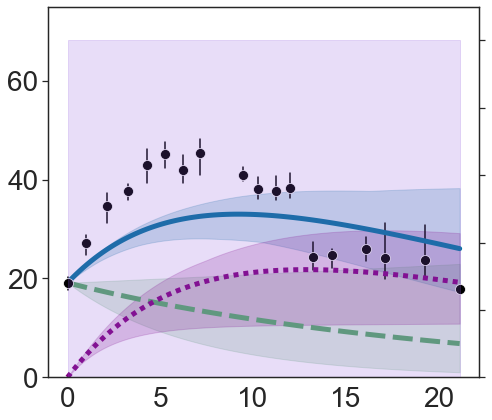

In [18]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelFitsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelFitsDf[modelFitsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=trainingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = trainingDataDf_avg.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,75)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/fits_CT_singleStepModel_%s.pdf"%cellLine)

### Test model by benchmarking its ability to predict response to an intermittent schedule

In [ ]:
# Load models and simulate
fitObj,myModel = LoadFit(modelName,fitDir=currOutDir)
bootstrapResultsDf = pd.read_csv(os.path.join(currOutDir, "bootstraps.csv"), index_col=0)
modelPredictionsDf = compute_confidenceInterval_prediction(fitObj=fitObj, bootstrapResultsDf=bootstrapResultsDf,
                                                     treatmentScheduleList=utils.ExtractTreatmentFromDf(testingDataDf_avg),
                                                     initialConditionsList={"P0":testingDataDf_avg.Confluence.iloc[0], "A0":0},
                                                     show_progress=True, n_time_steps=100,
                                                     alpha=ci_significanceLevel,
                                                     solver_kws=solver_kws, optimiser_kws=optimiser_kws)

In [ ]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(7,6))
# 1. Plot the model predictions and associated confidence intervals
sns.lineplot(x="Time",y="Estimate_MLE", hue="Variable", style="Variable",
             lw=5, palette=cycleArrestModelPalette,
             legend=False,
             data=modelPredictionsDf, ax=ax)
for var in cycleArrestModelPalette.keys():
    currDataDf = modelPredictionsDf[modelPredictionsDf.Variable==var]
    plt.fill_between(currDataDf.Time, currDataDf['CI_Lower_Bound'], 
                     currDataDf['CI_Upper_Bound'], color=cycleArrestModelPalette[var], alpha=0.2)
# 2. Plot the data
sns.lineplot(x="Time", y="Confluence", style="CellLine", err_style='bars',
             markers="o", lw=0, markersize=10, color="black",
             legend=False, data=testingDataDf_all, ax=ax)
# 3. Plot the drug concentration
tmpDf = testingDataDf_all.copy()
tmpDf.Confluence = np.nan
PlotData(tmpDf, y2lim=110, decorateY2=False, ax=ax)
ax.tick_params(labelsize=28)
ax.set_ylim(0,110)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("./figures/predictions_IMT7d_singleStepModel_%s.pdf"%cellLine)